<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/inceptionv3/transfer_learning_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import itertools
import numpy as np

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import InceptionV3 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    GlobalMaxPool1D,
    MaxPooling2D,
    Conv2D,
    BatchNormalization,
    Flatten,
    Dropout,
    Concatenate,
    Activation,
    Bidirectional,
)
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [34]:
!gdown https://drive.google.com/uc?id=1ysmhUNNwFoGr23F_YbVbbBCziPCfIUS3

Downloading...
From: https://drive.google.com/uc?id=1ysmhUNNwFoGr23F_YbVbbBCziPCfIUS3
To: /content/kaggle_sample.zip
2.05GB [00:25, 79.2MB/s]


In [35]:
!gdown https://drive.google.com/uc?id=1AnsT5cPD86Iza_bxCQhvqhYz5LAQM_WK

Downloading...
From: https://drive.google.com/uc?id=1AnsT5cPD86Iza_bxCQhvqhYz5LAQM_WK
To: /content/Messidor-2.zip
2.46GB [00:54, 44.8MB/s]


In [2]:
local_zip = '/content/kaggle_sample.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [3]:
local_zip = '/content/Messidor-2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
dr_dir = os.path.join('/content/kaggle_sample/train/dr')
no_dr_dir = os.path.join('/content/kaggle_sample/train/no_dr')

print("Total imagenes de entrenamiento Diabetic Retinopathy:", len(os.listdir(dr_dir)))
print(
    "Total imagenes de entrenamiento Non Diabetic Retinopathy:",
    len(os.listdir(no_dr_dir)),
)

Total imagenes de entrenamiento Diabetic Retinopathy: 1000
Total imagenes de entrenamiento Non Diabetic Retinopathy: 1000


In [5]:
dr_files = os.listdir(dr_dir)
no_dr_files = os.listdir(no_dr_dir)

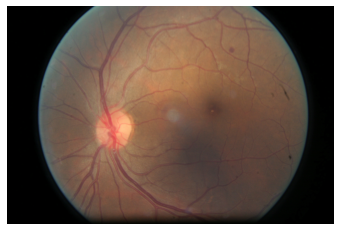

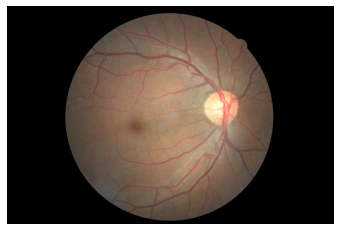

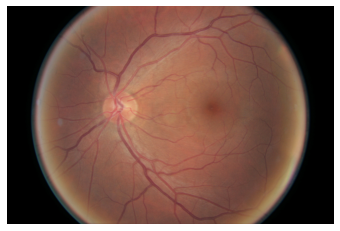

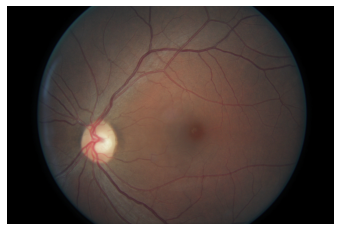

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_dr = [os.path.join(dr_dir, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(no_dr_dir, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [7]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/kaggle_sample/train"
TEST_DIR = "/content/Messidor-2"

BATCH_SIZE = 218
img_width, img_height = 299, 299

training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    brightness_range=[0.5,1.5],
    fill_mode='constant',
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 2000 images belonging to 2 classes.


In [25]:
training_datagen2 = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator2 = training_datagen2.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 2000 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


In [10]:
steps_per_epoch = train_generator.n // BATCH_SIZE
#validation_steps = img_iter_dev.n // BATCH_SIZE

In [11]:
train_generator.n

2000

In [12]:
BATCH_SIZE

218

In [13]:
steps_per_epoch

9

In [14]:
input_size = 299

## 1.2 Fine tunning 

#### Warmup
First we do a warmup training only the top layers:

In [15]:
base_model = InceptionV3(weights='imagenet', 
                   include_top=True,
                   input_shape=(input_size, input_size,3))

# Freeze the feature extractor (transfer learning)
for layer in base_model.layers:
    layer.trainable=False

base_model = Model(base_model.input, base_model.layers[-2].output) # Remove decision layer
x4 = BatchNormalization()(base_model.output)
x3 = Dropout(0.5)(x4)
x1 = Dense(512, activation='relu')(x3)
x0 = BatchNormalization()(x1)
x = Dense(1, activation='sigmoid')(x0)

visual_model = Model(inputs=base_model.input, outputs=x)

visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=['accuracy']
)

visual_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [16]:
visual_model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


3/9 [=========>....................] - ETA: 2:27 - loss: 0.8842 - accuracy: 0.5295

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/9 [===============>..............] - ETA: 1:52 - loss: 0.8663 - accuracy: 0.5725

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


7/9 [======================>.......] - ETA: 59s - loss: 0.8559 - accuracy: 0.5840 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 276s 31s/step - loss: 0.8542 - accuracy: 0.5971
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


1/9 [==>...........................] - ETA: 8:25 - loss: 0.9034 - accuracy: 0.6606

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/9 [===============>..............] - ETA: 2:38 - loss: 0.7730 - accuracy: 0.6752

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 334s 37s/step - loss: 0.7724 - accuracy: 0.6667
Epoch 3/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 273s 30s/step - loss: 0.6854 - accuracy: 0.6904
Epoch 4/20
9/9 [==============================] - 335s 37s/step - loss: 0.6463 - accuracy: 0.7069
Epoch 5/20
8/9 [=========================>....] - ETA: 33s - loss: 0.6274 - accuracy: 0.7148 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 336s 37s/step - loss: 0.6149 - accuracy: 0.7155
Epoch 6/20
9/9 [==============================] - 277s 31s/step - loss: 0.5890 - accuracy: 0.7267
Epoch 7/20
9/9 [==============================] - 338s 38s/step - loss: 0.5242 - accuracy: 0.7430
Epoch 8/20
9/9 [==============================] - 277s 31s/step - loss: 0.5276 - accuracy: 0.7397
Epoch 9/20
9/9 [==============================] - 333s 37s/step - loss: 0.5088 - accuracy: 0.7569
Epoch 10/20
9/9 [==============================] - 273s 30s/step - loss: 0.5017 - accuracy: 0.7609
Epoch 11/20
9/9 [==============================] - 302s 34s/step - loss: 0.4749 - accuracy: 0.7856
Epoch 12/20
9/9 [==============================] - 265s 29s/step - loss: 0.4493 - accuracy: 0.7864
Epoch 13/20
9/9 [==============================] - 327s 36s/step - loss: 0.4328 - accuracy: 0.7929
Epoch 14/20
9/9 [==============================] - 265s 29s/step - loss: 0.4044 - accuracy: 0.8081
Epoch 15/20
9/9 [=========

#### Unfreeze the extractor layers:
- Allow some of the layers to train with a reduced learning rate  

In [17]:
# Unfreeze the extractor layers
for layer in visual_model.layers[-5:]:
    layer.trainable = True

# change the learning rate
visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=['accuracy']
)

# train
history = visual_model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch
    )

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


2/9 [=====>........................] - ETA: 4:01 - loss: 0.3479 - accuracy: 0.8417

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/9 [============>.................] - ETA: 2:48 - loss: 0.3559 - accuracy: 0.8372

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


6/9 [===================>..........] - ETA: 1:40 - loss: 0.3714 - accuracy: 0.8257

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 274s 30s/step - loss: 0.3777 - accuracy: 0.8283
Epoch 2/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/9 [===============>..............] - ETA: 2:39 - loss: 0.3508 - accuracy: 0.8422

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 335s 37s/step - loss: 0.3587 - accuracy: 0.8369
Epoch 3/20
1/9 [==>...........................] - ETA: 42s - loss: 0.3406 - accuracy: 0.8421

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/9 [============>.................] - ETA: 2:49 - loss: 0.3482 - accuracy: 0.8555

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 276s 31s/step - loss: 0.3507 - accuracy: 0.8552
Epoch 4/20
3/9 [=========>....................] - ETA: 4:24 - loss: 0.3490 - accuracy: 0.8517

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 337s 37s/step - loss: 0.3443 - accuracy: 0.8537
Epoch 5/20
9/9 [==============================] - 337s 37s/step - loss: 0.3759 - accuracy: 0.8440
Epoch 6/20
9/9 [==============================] - 276s 31s/step - loss: 0.3390 - accuracy: 0.8547
Epoch 7/20
9/9 [==============================] - 340s 38s/step - loss: 0.3194 - accuracy: 0.8648
Epoch 8/20
9/9 [==============================] - 275s 31s/step - loss: 0.3337 - accuracy: 0.8625
Epoch 9/20
9/9 [==============================] - 339s 38s/step - loss: 0.3283 - accuracy: 0.8664
Epoch 10/20
9/9 [==============================] - 268s 30s/step - loss: 0.3447 - accuracy: 0.8676
Epoch 11/20
9/9 [==============================] - 269s 30s/step - loss: 0.3303 - accuracy: 0.8591
Epoch 12/20
9/9 [==============================] - 332s 37s/step - loss: 0.3014 - accuracy: 0.8844
Epoch 13/20
9/9 [==============================] - 331s 37s/step - loss: 0.3332 - accuracy: 0.8578
Epoch 14/20
9/9 [==========

#### Metrics on Train set (Kaggle-sample)

In [33]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)

In [37]:
ans = next(img_iter_val_0)[1]

In [38]:
ans

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(train_generator2.n)).astype('int')

In [26]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob_visual = visual_model.predict_generator(train_generator2)
y_pred = (y_pred_prob_visual> threshold).astype('int')

KeyboardInterrupt: ignored

In [27]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

ValueError: ignored

#### Metrics on Test set (Messidor-2)

In [20]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(test_generator, 2)
y_true = test_generator.classes

In [21]:
y_pred_prob_visual = visual_model.predict_generator(test_generator)
y_pred = (y_pred_prob_visual> threshold).astype('int')

In [22]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

Accuracy: 0.5881006864988558
AUC: 0.5469878089690099


### Notes 


**Messidor**
* Data comes from http://www.adcis.net/en/third-party/messidor2/

* Labels from https://www.kaggle.com/google-brain/messidor2-dr-grades?select=messidor_data.csv